In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

plt.style.use('dark_background')

In [87]:
df = pd.read_csv('cleaned.csv', parse_dates=['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  420768 non-null  datetime64[ns]
 1   year      420768 non-null  int64         
 2   month     420768 non-null  int64         
 3   day       420768 non-null  int64         
 4   hour      420768 non-null  int64         
 5   PM2.5     412029 non-null  float64       
 6   PM10      414319 non-null  float64       
 7   SO2       411747 non-null  float64       
 8   NO2       408652 non-null  float64       
 9   CO        400067 non-null  float64       
 10  O3        407491 non-null  float64       
 11  TEMP      420370 non-null  float64       
 12  PRES      420375 non-null  float64       
 13  DEWP      420365 non-null  float64       
 14  RAIN      420378 non-null  float64       
 15  wd        418946 non-null  object        
 16  WSPM      420450 non-null  float64    

In [62]:
missing = df.isna().sum()
print(missing)

year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64


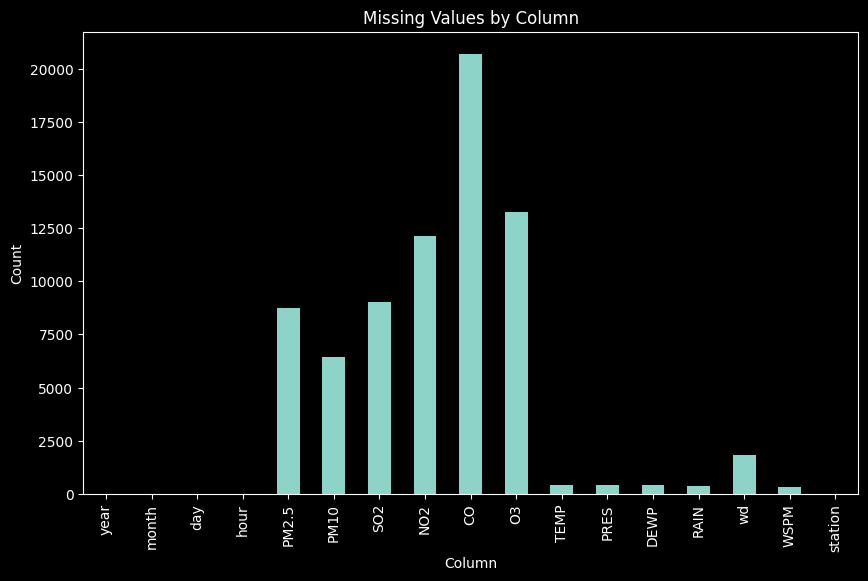

In [143]:
missing.plot(kind='bar', figsize=(10, 6))
plt.title('Missing Values by Column')
plt.ylabel('Count')
plt.xlabel('Column')
plt.show()

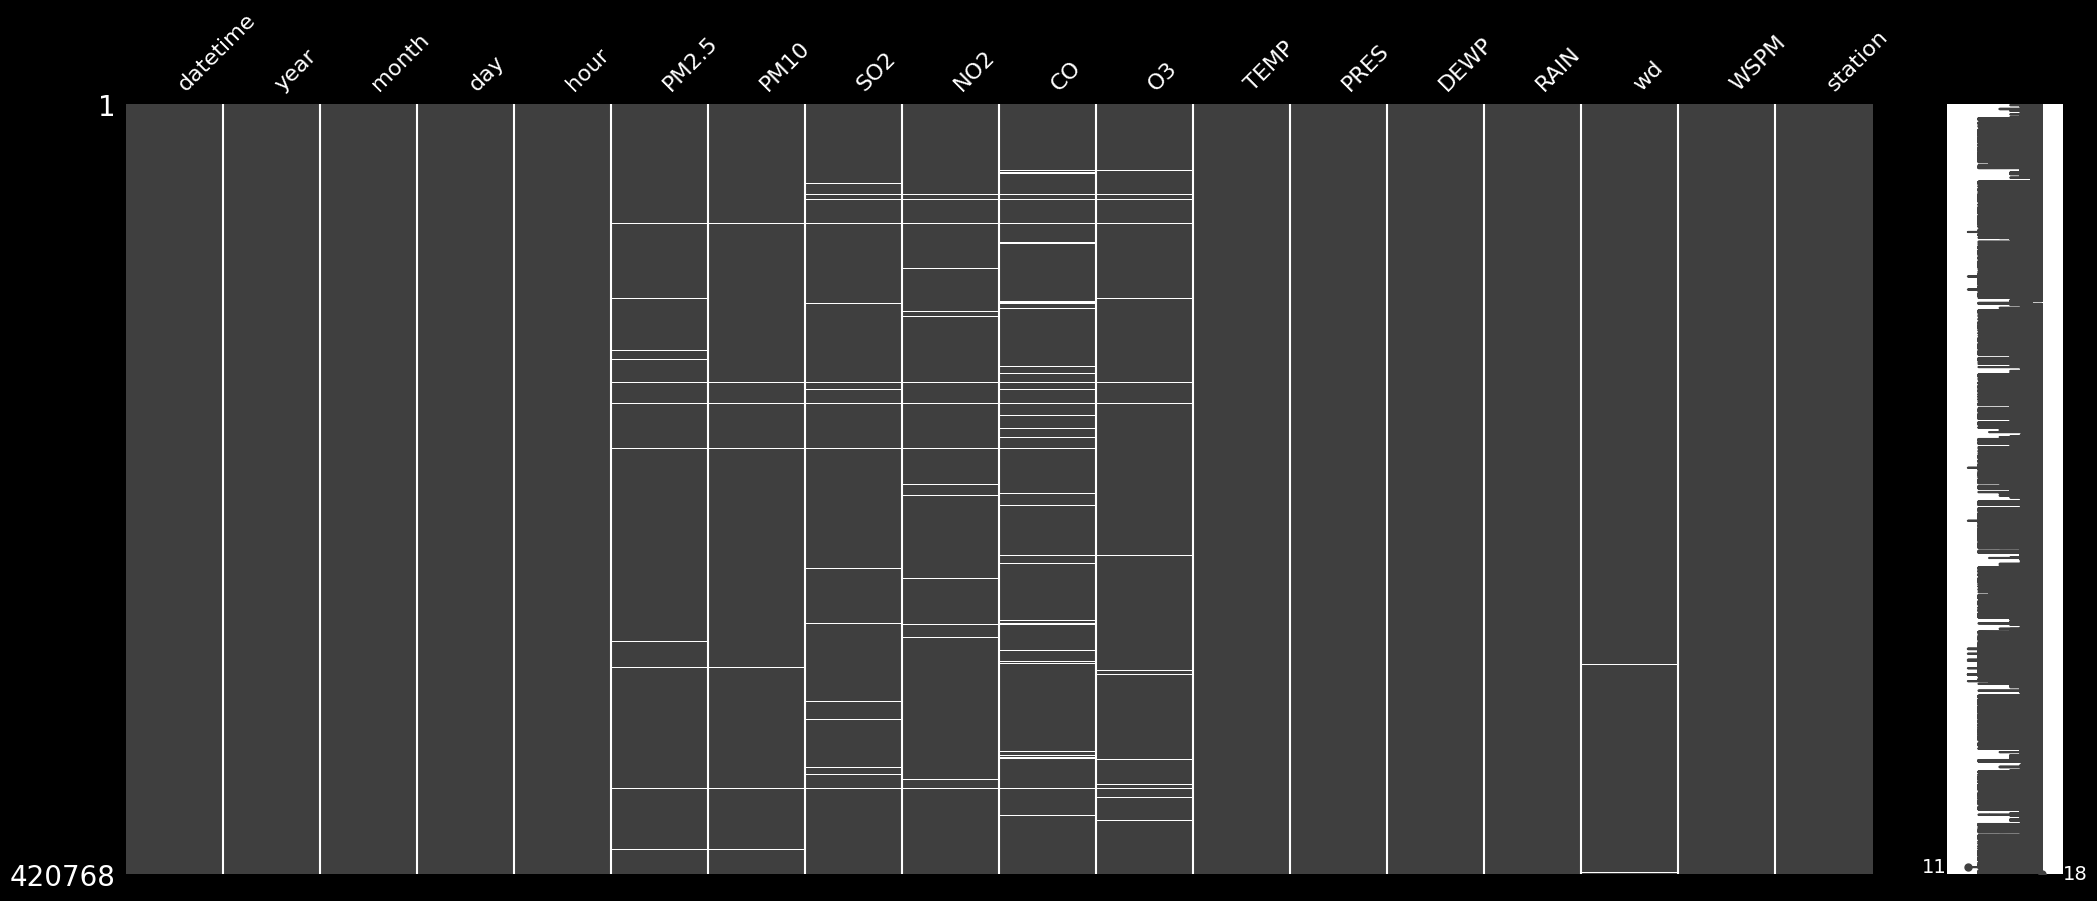

In [144]:
msno.matrix(df)
plt.show()

If we wipe the rows with missing data we would remove ~5% of our total dataset (approx. 20000/420000). We can see from the above matrix that the missing values are quite sparsely distributed and we wouldn't be removing any one significant chunk of data if we `df.dropna()`. However, the plan is to use XGBoost and other algorithms that handle missing data well, so I've opted to keep the data for now.

If I were to handle the missing values, I would likely use an imputation method like interpolation to fill these rows, because the pollutant data is continuous and only missing in small bursts, I think this would be a sufficient method to uphold the quality of the data.

In [97]:
stat_cols = list(df.select_dtypes(include='float64').columns)
df[stat_cols].describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [114]:
monthly_avg = df[stat_cols+['datetime', 'station']].set_index('datetime')
monthly_avg = monthly_avg.groupby('station').resample('ME').mean().reset_index()

stations = monthly_avg['station'].unique()
num_stations = len(stations)

pollutants = stat_cols[:6]

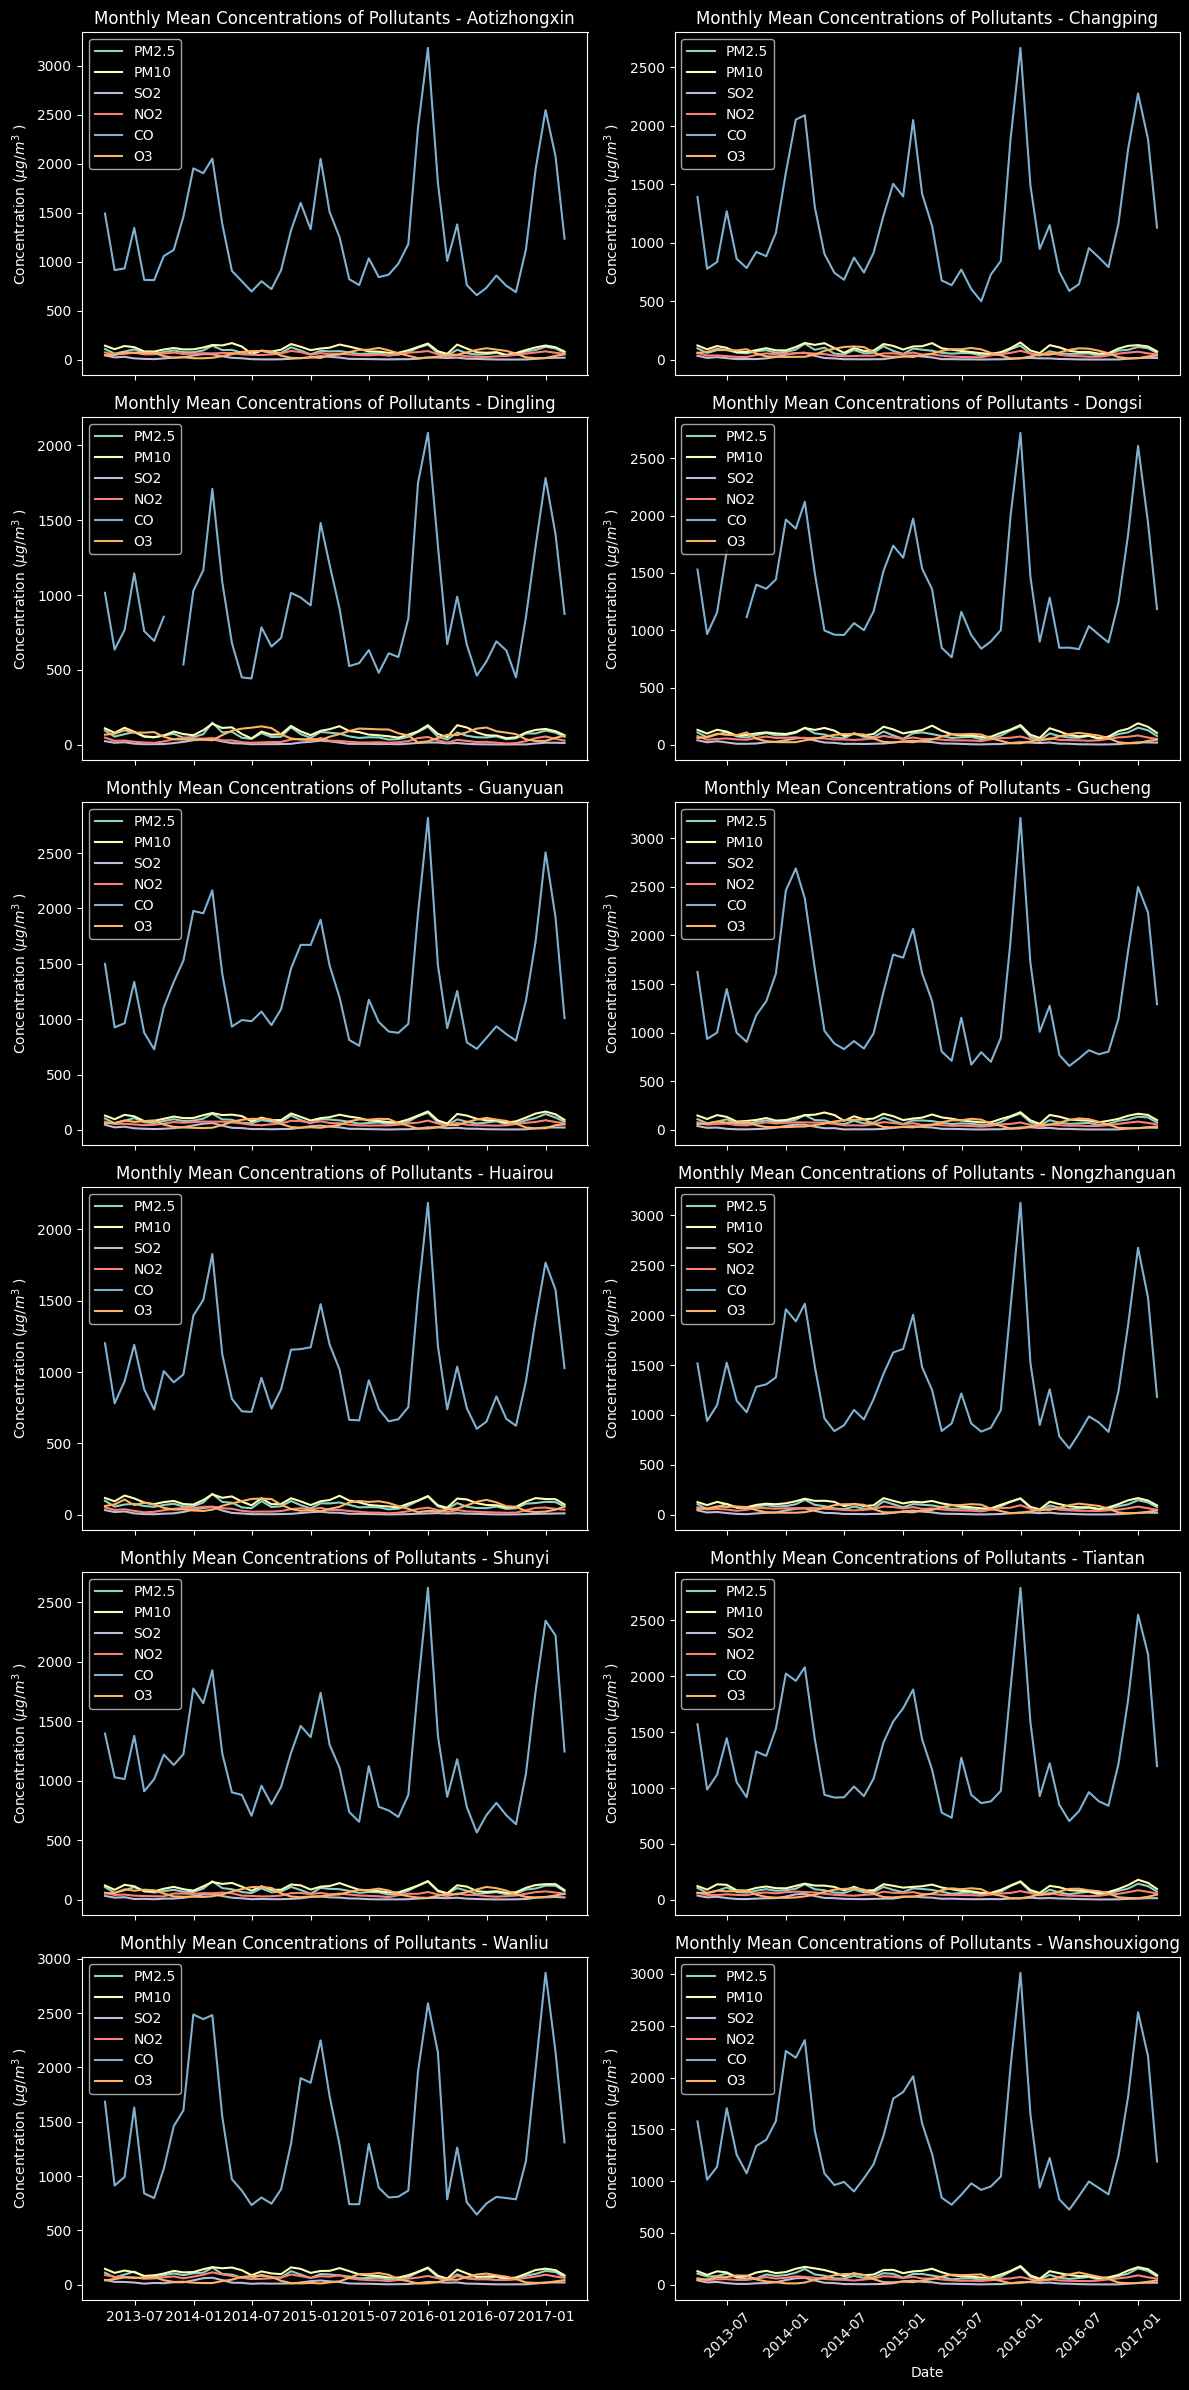

In [ ]:
fig, axes = plt.subplots(nrows=num_stations//2, ncols=2, sharex=True, figsize=(12, 2 * num_stations))
axes = axes.ravel()

for ax, station in zip(axes, stations):
    station_data = monthly_avg[monthly_avg['station'] == station]
    
    for pollutant in pollutants:
        ax.plot(station_data['datetime'], station_data[pollutant], label=pollutant)
    ax.set_title(f"Monthly Mean Concentrations of Pollutants - {station}")
    ax.set_ylabel(r"Concentration ($\mu g/m^3$ )")
    ax.legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

Seeing a clear seasonal trend in carbon monoxide levels with massive spikes in the winter season, which makes sense because a primary driver of CO emissions is through burning fossil fuels for heating and electricity, as well as motor vehicles.

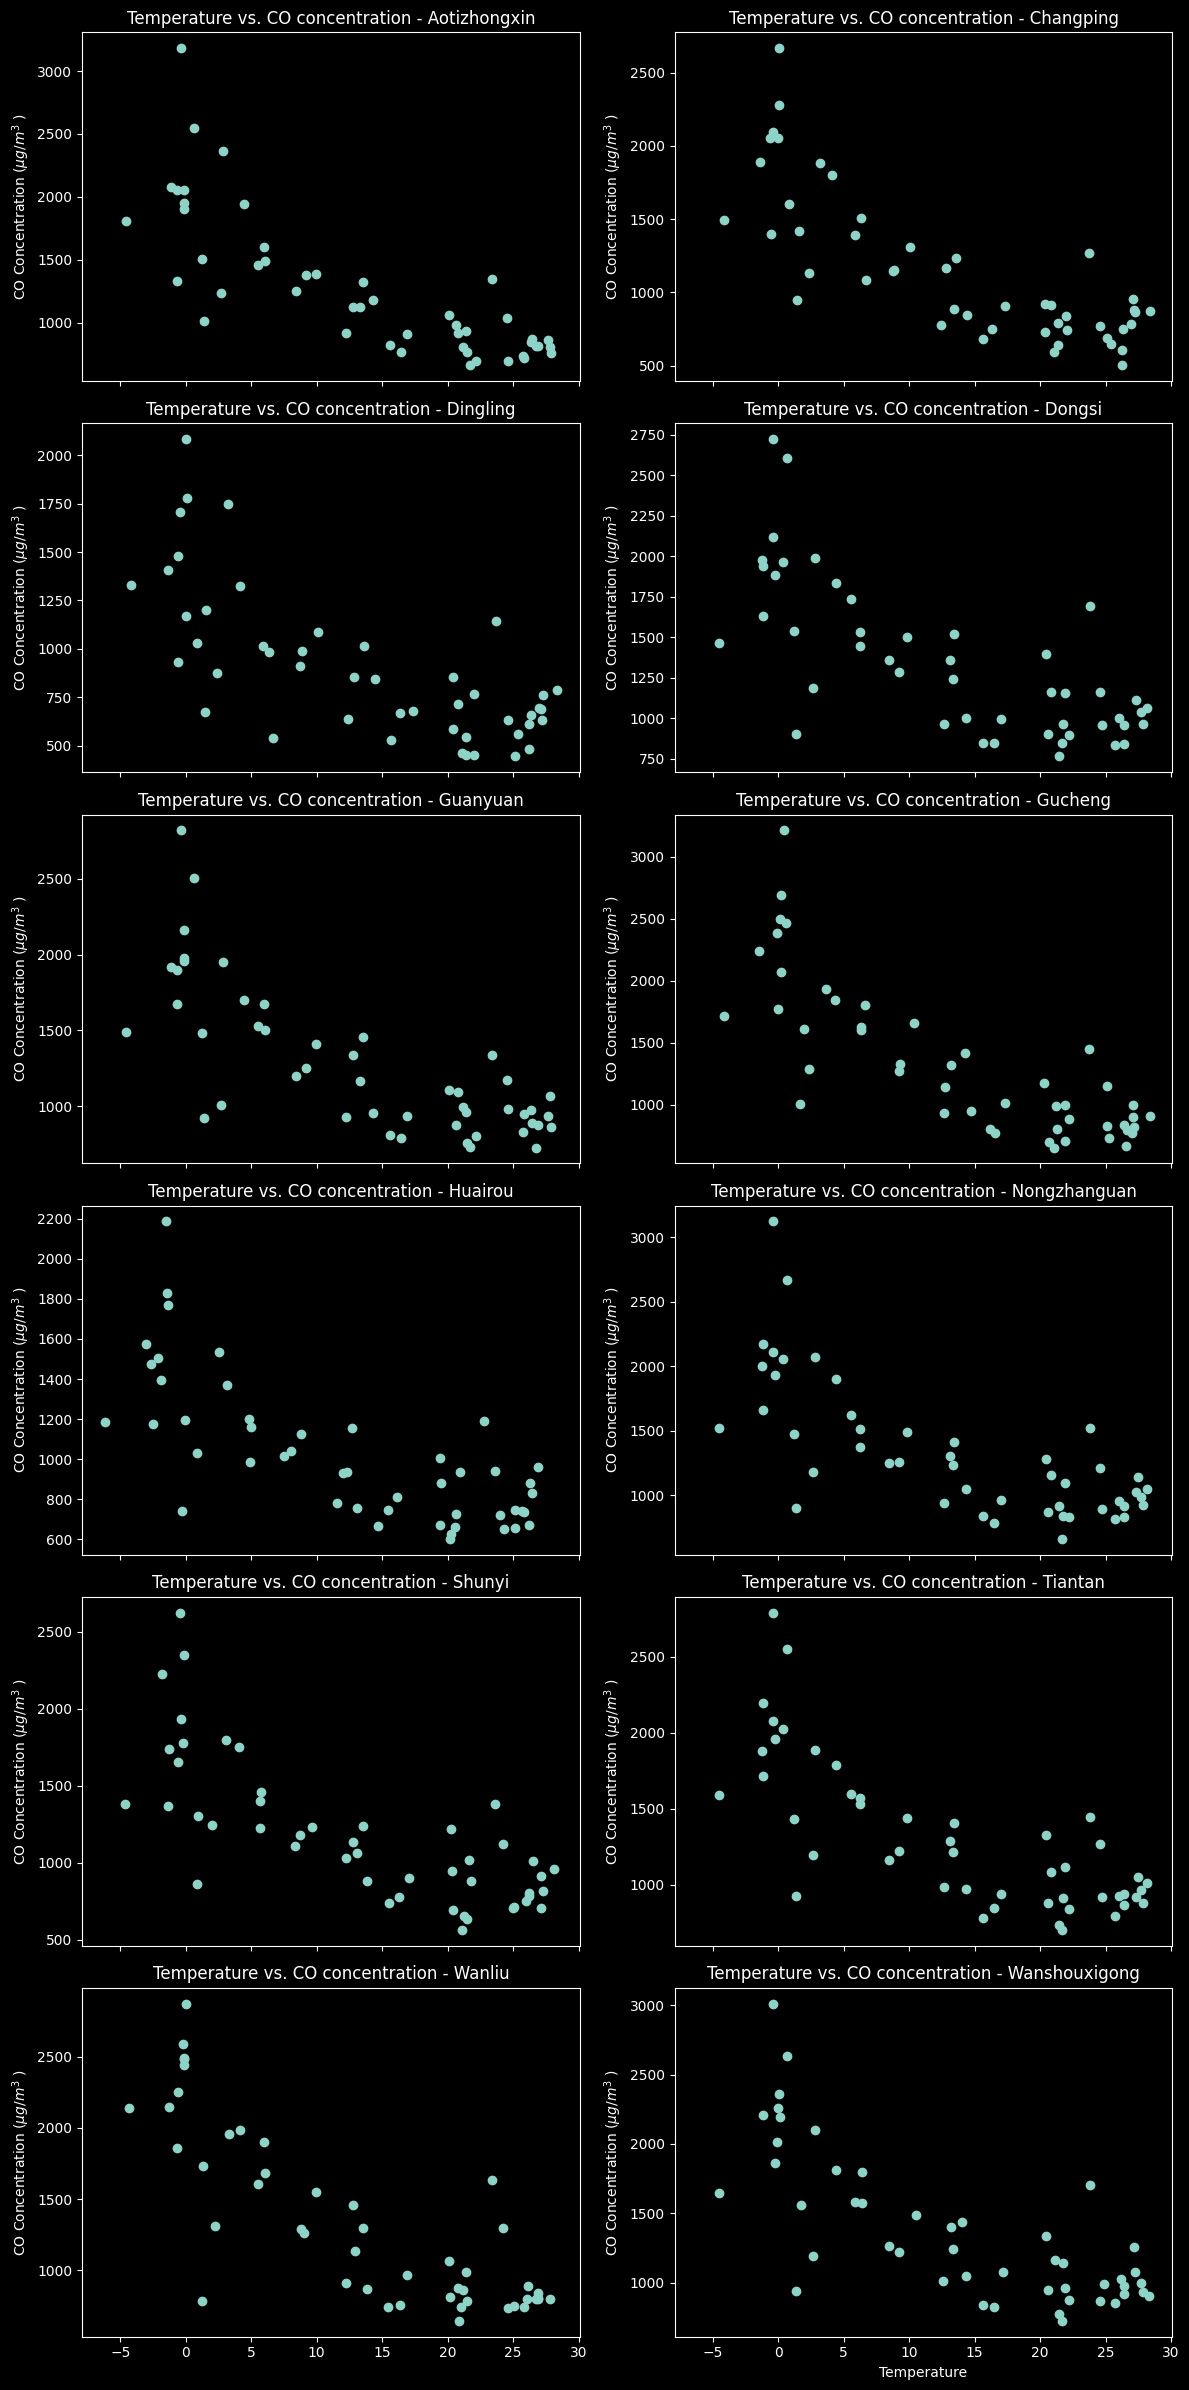

In [150]:
fig, axes = plt.subplots(nrows=num_stations//2, ncols=2, sharex=True, figsize=(12, 2 * num_stations))
axes = axes.ravel()

for ax, station in zip(axes, stations):
    station_data = monthly_avg[monthly_avg['station'] == station]
    
    ax.scatter(station_data['TEMP'], station_data['CO'])
    ax.set_title(f"Temperature vs. CO concentration - {station}")
    ax.set_ylabel(r"CO Concentration ($\mu g/m^3$ )")

plt.xlabel('Temperature')
plt.tight_layout()
plt.show()

<Axes: >

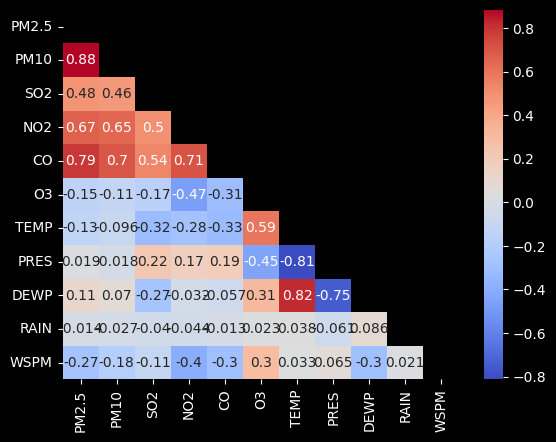

In [151]:
corr_matrix = df[stat_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm')